In [9]:
import numpy as np
import numpy.typing as npt

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
%matplotlib inline
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('png')

#plt.style.use('dark_background')

from jupyterthemes import jtplot
jtplot.style()

import os
import sys
module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)

import glickbest

%reload_ext autoreload
%aimport glickbest

In [16]:
true_ratings = np.array([1500, 1500, 1500, 1500, 1600], dtype=np.float64)

def sim(n_sim=100, n_rounds=200, rand=False):
    plot_data = []
    for _ in tqdm(range(n_sim)):
        glicko = np.array([[1500, 200]]*len(true_ratings), dtype=np.float64)
        y_plot = []
        for _ in range(n_rounds):
            p_best = glickbest.rank1_probs(glicko, num_samples=2000)
            lp = np.zeros_like(p_best)
            np.log2(p_best, out=lp, where=(p_best > 0))
            lp *= p_best
            p_best_perplexity = np.power(2, -np.sum(lp))
            y_plot.append(p_best_perplexity)
            if rand:
                i, j = np.random.choice(np.arange(len(p_best)), 2)
            else:
                i, j = glickbest.top_k(p_best, k=2)
            p_win = glickbest.win_prob_bradley_terry(true_ratings[i], true_ratings[j])
            s = np.random.binomial(1, p_win)
            glickbest.update(glicko, i, j, s)
        plot_data.append(y_plot)
    return np.array(plot_data)

In [17]:
sim_data = sim()
rand_data = sim(rand=True)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

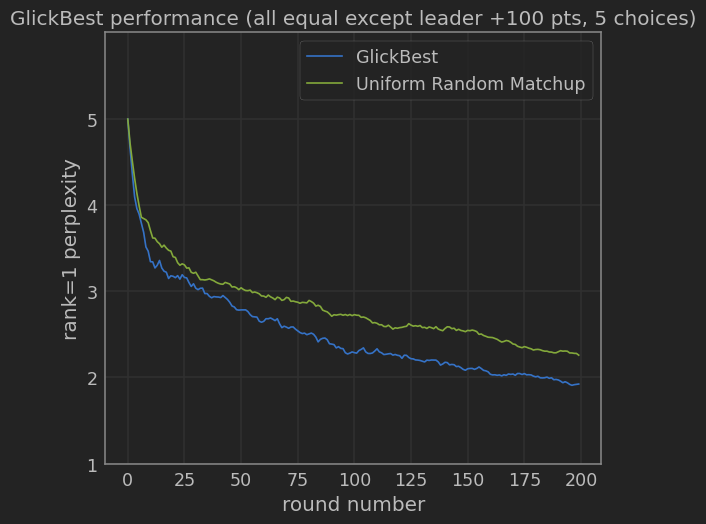

In [18]:
fig, ax = plt.subplots()

def mean_with_std(ax, data, label):
    y_plot = np.mean(data, axis=0)
    yerr_plot = np.std(data, axis=0)
    x_plot = np.arange(len(y_plot))
    # ax.plot(x_plot, y_plot, yerr=yerr_plot, marker=".", capsize=3, label=label)
    ax.plot(x_plot, y_plot, marker="", label=label)

ax.set_title("GlickBest performance (all equal except leader +100 pts, 5 choices)")
mean_with_std(ax, sim_data, "GlickBest")
mean_with_std(ax, rand_data, "Uniform Random Matchup")
ax.set_ylim([1., np.max(sim_data) + 1.])
ax.set_xlabel("round number")
ax.set_ylabel("rank=1 perplexity")
ax.legend()